In [1]:
import networkx as nx
import numpy as np
from plfit import plfit
import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle

from collections import Counter
from utils import ReachFinder

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

In [2]:
G = nx.read_gexf("../../PyPi Network V3.gexf")
print(G)

DiGraph with 168382 nodes and 783493 edges


## Distribuciones de Grado

/home/agus/mambaforge/envs/facu39/lib/python3.9/site-packages/plfit/plfit.py:1012: RuntimeWarning: divide by zero encountered in log
  alpha = 1.0 + float(nn) * (sum(log(xx/(float(xmin)-0.5))))**-1
/home/agus/mambaforge/envs/facu39/lib/python3.9/site-packages/plfit/plfit.py:1012: RuntimeWarning: invalid value encountered in log
  alpha = 1.0 + float(nn) * (sum(log(xx/(float(xmin)-0.5))))**-1
/home/agus/mambaforge/envs/facu39/lib/python3.9/site-packages/plfit/plfit.py:1065: RuntimeWarning: divide by zero encountered in true_divide
  model_cdf = 1.0-(zz.astype('float')/float(xmin))**(1.0-alpha)
/home/agus/mambaforge/envs/facu39/lib/python3.9/site-packages/plfit/plfit.py:1065: RuntimeWarning: invalid value encountered in true_divide
  model_cdf = 1.0-(zz.astype('float')/float(xmin))**(1.0-alpha)


Grado Out
k_max = 29110
gamma = (1.78 ± 0.01)
k_min = 12
k_sat = 0.0096
Grado In
k_max = 453
gamma = (3.52 ± 0.05)
k_min = 27
k_sat = 0.0108
k_mean = 4.65


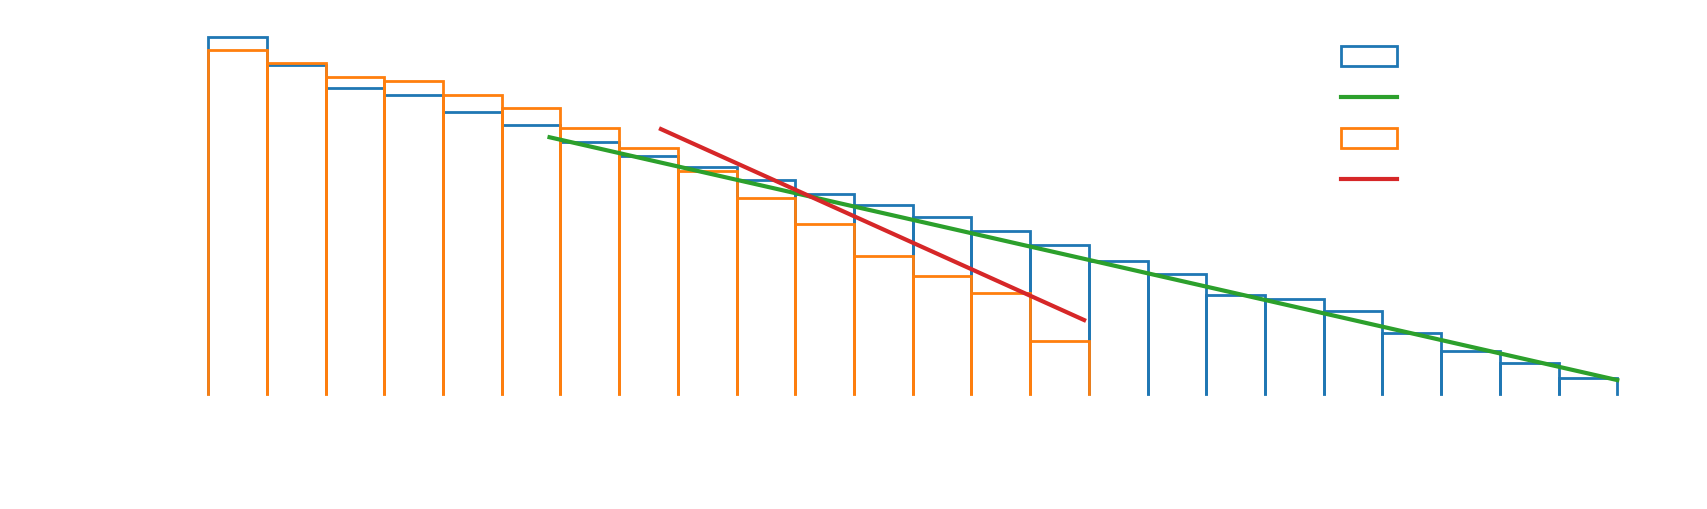

In [13]:
k_out = np.array([k for node, k in G.out_degree()])
k_in = np.array([k for node, k in G.in_degree()])
logbin = np.geomspace(1, max([max(k_out), max(k_in)]), 25)
dense_logbin = np.geomspace(1, logbin[-1], 1000)
with plt.rc_context({
    'text.color': "w",
    'axes.labelcolor': "w",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
    ax.patch.set_alpha(0.)
    for spine in ax.spines.values():
        spine.set_edgecolor('w')
    i = 0
    for k, tag, k_max in zip([k_out, k_in],
                             ["Grado Out", "Grado In",],
                             [3e4, 6e2]):
        hist = ax.hist(k, bins=logbin, density=True,
                       fill=False, edgecolor=f"C{i}", label=tag, )
        
        fit = plfit(k)
        k_min = fit._xmin
        gamma = fit._alpha
        gamma_err = fit._alphaerr
        k_sat = fit._ks
        print(tag)
        print(f"k_max = {max(k)}")
        print(f"gamma = ({gamma:.2f} ± {gamma_err:.1g})",
            f"k_min = {k_min}", f"k_sat = {k_sat:.3g}", sep="\n")
        norm = np.sum(hist[1]>k_min)
        # dist = dict(Counter(k))
        # ax.scatter(dist.keys(), np.array(list(dist.values()))/np.sum(hist[1]),
        #            alpha=0.3, edgecolors=f"C{i}")
        y = ((gamma-1)*k_min**(gamma-1)*dense_logbin**(-gamma))/norm
        i += 1
        ax.plot(dense_logbin[(dense_logbin > k_min) & (dense_logbin <= k_max)],
                y[(dense_logbin > k_min) & (dense_logbin <= k_max)],
                c=f"C{i+1}", label=f"Ajuste {tag}")
    print(f"k_mean = {np.mean(k_in):.3g}")
    ax.legend(frameon=False)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Grado")
    ax.set_ylabel("Densidad")
    plt.show()

## Alcance de los nodos

In [3]:
def get_reach(G: nx.Graph, p: float = 1) -> pd.DataFrame:
    """
    Get reach of each node for a given probability 'p'.

    Args:
        G (nx.Graph): Networkx Graph.
        p (float, optional): Probability 'p'. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame with reach of each node.
    """

    search = ReachFinder(G, p = p)

    # Find reach of each node.
    reach_by_node = search.find_all_nodes()
    reach_by_node = search.remove_self_edges(reach_by_node)

    # Sort libs by reach descending.
    reach_amount = dict(sorted([(k, len(v)) for k, v in reach_by_node.items()], key = lambda x: x[1], reverse=True))
    reach_df = pd.DataFrame([(k, v) for k, v in reach_amount.items()], columns = ["Library", "Reach"]).set_index("Library")

    return reach_df

reach_by_node = get_reach(G, p = 1)

Done. Function called 168382 times.


## K-Coreness

In [39]:
def delete_by_degree(G: nx.Graph, k = 0, kind="out"):
    G_copy = G.copy()
    if kind == "out":
        degree_dict = G.out_degree()
    elif kind == "in":
        degree_dict = G.in_degree()
    node_degree = dict(sorted(degree_dict, key=lambda x: x[1]))
    k_nodes = [n for n in G_copy.nodes() if node_degree[n] == k]

    if len(k_nodes) != 0:
        G_copy.remove_nodes_from(k_nodes)
    else:
        G_copy = delete_by_degree(G = G_copy, k = k+1)
    return G_copy

def k_coreness(G, kind="out"):
    coreness = {node: 0 for node in G.nodes()}
    G_copy = G.copy()

    i = 1
    
    while G_copy.nodes():

        G_copy = delete_by_degree(G_copy, k = 0, kind=kind)

        prevalent_nodes = G_copy.nodes()
        for node in prevalent_nodes:
            coreness[node] += 1

        i += 1
    
    return coreness

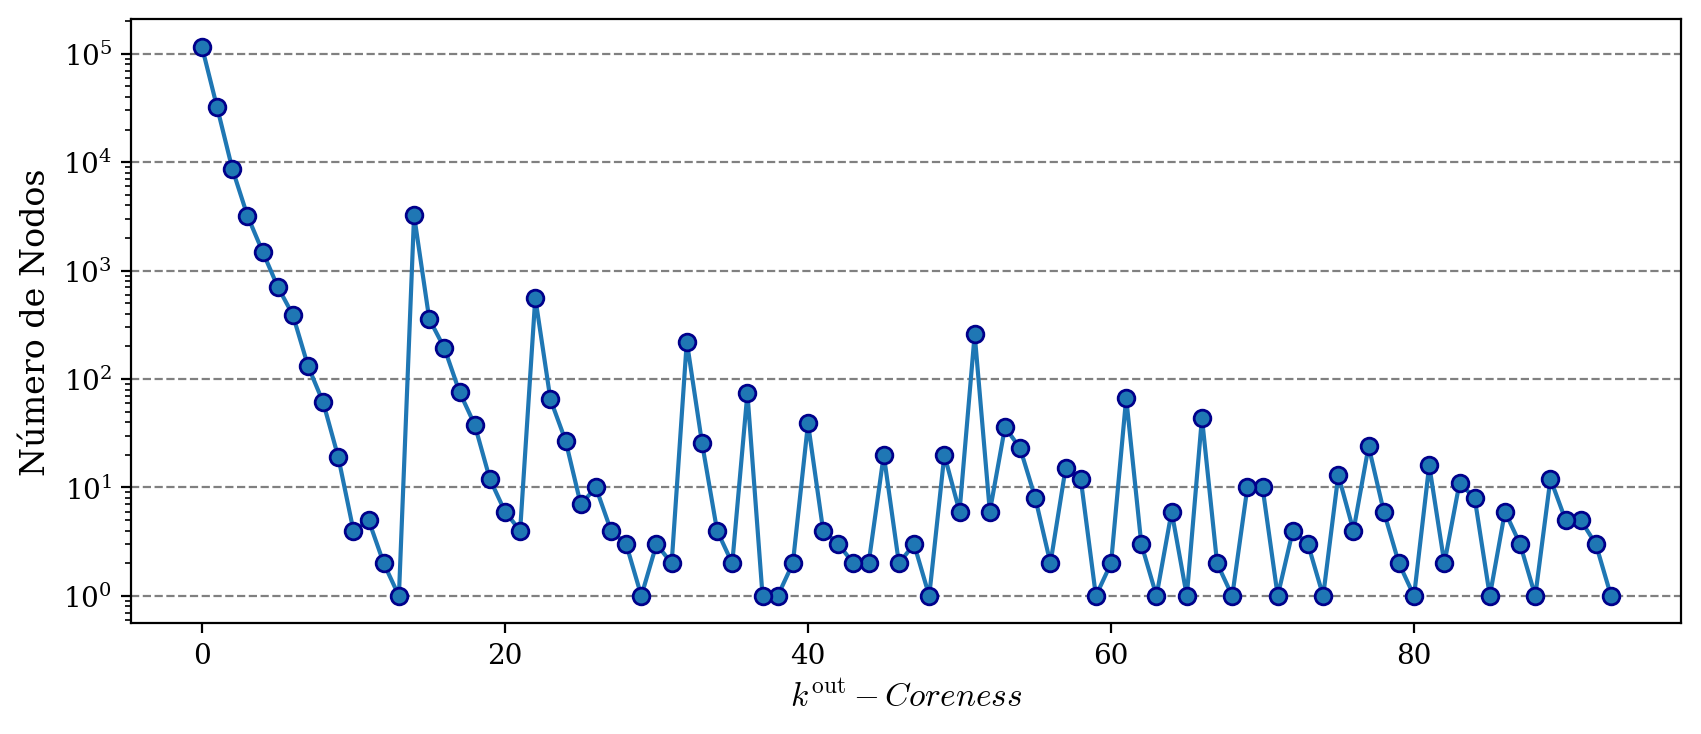

In [42]:
coreness = k_coreness(G, "out")
coreness = dict(sorted(list(coreness.items()), key = lambda x: x[1], reverse=True))
count_coreness = Counter(coreness.values())

with plt.rc_context({
    'text.color': "k",
    'axes.labelcolor': "k",
    'xtick.color': "k",
    'ytick.color': "k",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.patch.set_alpha(0.)
    for spine in ax.spines.values():
        spine.set_edgecolor("k")

    ax.plot(count_coreness.keys(), count_coreness.values(), 'o-', mec="darkblue", mew=1, zorder=10)
    # ax.hist(coreness.values(), bins=60, fill=False, edgecolor="darkblue", linewidth=1.5, zorder=10)
    ax.set_yscale("log")
    ax.set_xlabel("$k^{\mathrm{out}}-Coreness$")
    ax.set_ylabel("Número de Nodos")
    # ax.set_title("Distribución de\n$K-Coreness$ en la red")
    ax.grid(color="gray", ls="--", axis = "y")
    plt.show()

## Gráficos

In [3]:
comp = sorted(list(nx.connected_components(nx.Graph(G))), key = len, reverse=True)
comp_len = [len(c) for c in comp]
comp_len_counts = dict(Counter(comp_len))

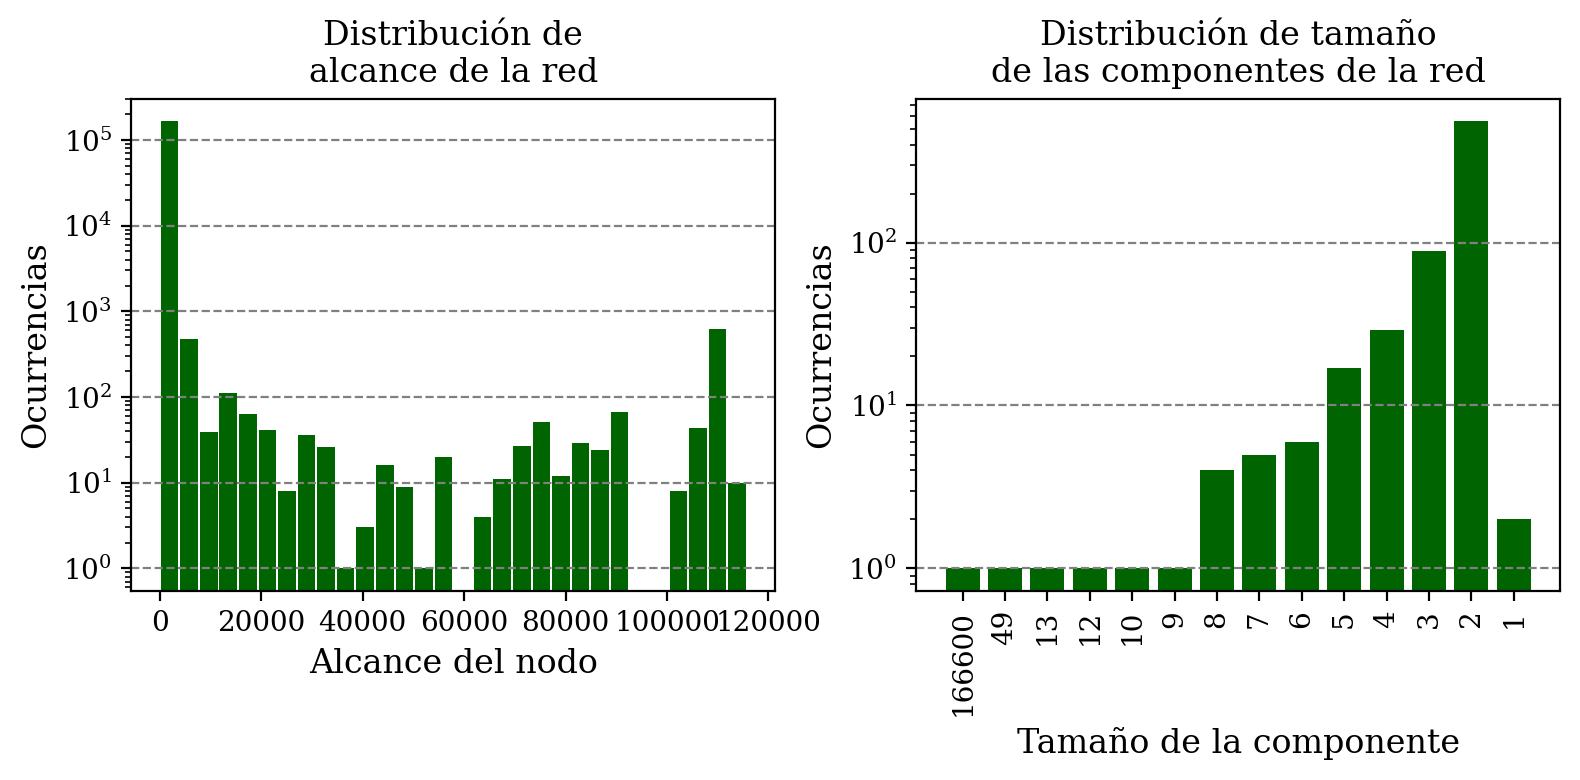

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

# Histograma de alcance de los nodos.
ax[0].hist(reach_by_node["Reach"], bins = 30, rwidth=0.90, color="darkgreen")
ax[0].set_yscale("log")
ax[0].grid(color="gray", ls="--", axis="y")
ax[0].set_xlabel("Alcance del nodo")
ax[0].set_ylabel("Ocurrencias")
ax[0].set_title("Distribución de\nalcance de la red")

# Distribución de componentes en la red.
ax[1].bar(range(len(comp_len_counts)), comp_len_counts.values(), color="darkgreen")
ax[1].set_xticks(range(len(comp_len_counts)))
ax[1].set_xticklabels(comp_len_counts.keys(), rotation = 90)
ax[1].set_yscale("log")
ax[1].grid(color="gray", ls="--", axis="y")
ax[1].set_xlabel("Tamaño de la componente")
ax[1].set_ylabel("Ocurrencias")
ax[1].set_title("Distribución de tamaño\nde las componentes de la red")

plt.show()

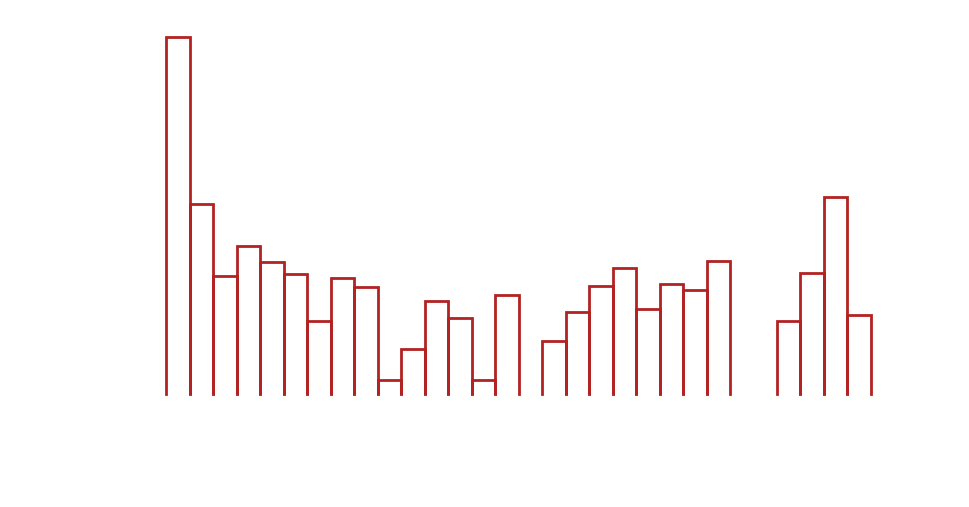

In [14]:
with plt.rc_context({
    'text.color': "w",
    'axes.labelcolor': "w",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    ax.patch.set_alpha(0.)
    for spine in ax.spines.values():
        spine.set_edgecolor('w')
    
    # logbin = np.geomspace(1, max(reach_by_node["Reach"]), 30)
    ax.hist(reach_by_node["Reach"], bins=30, fill=False, edgecolor="firebrick")
    ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.set_xlabel("Alcance")
    ax.set_ylabel("Ocurrencias")
    plt.show()

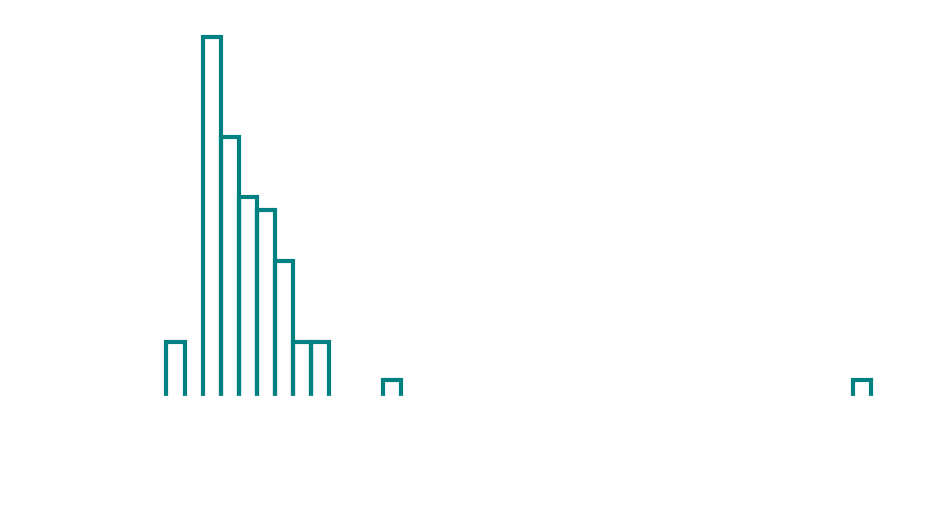

In [24]:
with plt.rc_context({
    'text.color': "w",
    'axes.labelcolor': "w",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    ax.patch.set_alpha(0.)
    for spine in ax.spines.values():
        spine.set_edgecolor("w")
    logbin = np.geomspace(1, max(comp_len), 40)
    ax.hist(comp_len, bins=logbin, fill=False, edgecolor="teal", linewidth=1.5)
    # ax.scatter(comp_len_counts.keys(), comp_len_counts.values(), edgecolors="teal", c="teal", alpha=0.5, )
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Tamaño de la Componente")
    ax.set_ylabel("Ocurrencias")
    plt.show()

- La componente 1 es...
- La componente 2 son todos los paquetes de https://github.com/musculoskeletal/gias3.

## Librerias con mayor alcance.

Elegimos estas porque después hay un salto significativo en el alcance.

In [15]:
top_reach_libs = list(reach_by_node["Reach"].head(679).index)
top_reach_libs

['numpy',
 'six',
 'django',
 'typing-extensions',
 'pyyaml',
 'pillow',
 'jinja2',
 'cython',
 'chardet',
 'matplotlib',
 'cssselect',
 'genshi',
 'webencodings',
 'html5lib',
 'lxml',
 'python-dateutil',
 'backports-functools-lru-cache',
 'pytz',
 'sqlalchemy',
 'colorama',
 'flask',
 'sphinx',
 'railroad-diagrams',
 'pyparsing',
 'typing',
 'soupsieve',
 'beautifulsoup4',
 'docopt',
 'wcwidth',
 'pycparser',
 'cffi',
 'packaging',
 'markdown',
 'pygments',
 'tornado',
 'tomli',
 'docutils',
 'dataclasses',
 'coverage',
 'regex',
 'bump2version',
 'sphinxcontrib-httpdomain',
 'transifex-client',
 'sphinx-rtd-theme',
 'nose',
 'tabulate',
 'pbr',
 'pip',
 'prompt-toolkit',
 'cached-property',
 'lark-parser',
 'h5py',
 'mypy-extensions',
 'xmltodict',
 'sortedcontainers',
 'typing-inspect',
 'mistune',
 'tomlkit',
 'greenlet',
 'pyopenssl',
 'certifi',
 'decorator',
 'arrow',
 'jupyter',
 'pyzmq',
 'werkzeug',
 'backports-zoneinfo',
 'pycodestyle',
 'tokenize-rt',
 'stevedore',
 'ptypr

In [9]:
top_reach_libs = list(reach_by_node["Reach"].head(679).index)

with open("../../PyPi filtered DataFrame.df", "rb") as f:
    df = pickle.load(f)

df.head(5)

,Dependencies,Tags,Licence,Package Version,Python Version,Classifiers,Dependant Libraries Count,Programming Language
0-core-client,[redis],None,Apache 2.0,1.1.0a8,None,[],0.0,None
0-orchestrator,"[jinja2, aioredis, etcd3, netaddr, python-date...",None,Apache 2.0,1.1.0a8,None,[],0.0,None
01d61084-d29e-11e9-96d1-7c5cf84ffe8e,"[click, attrs]",None,None,0.1.0,">=3.7,<4.0","[Programming Language :: Python :: 3, Programm...",2.0,Python
0x-contract-addresses,"[mypy-extensions, bandit, black, coverage, cov...",ethereum cryptocurrency 0x decentralized block...,Apache 2.0,3.0.0,">=3.6, <4","[Development Status :: 5 - Production/Stable, ...",6.0,Python
0x-contract-artifacts,"[mypy-extensions, bandit, black, coverage, cov...",ethereum cryptocurrency 0x decentralized block...,Apache 2.0,3.0.0,">=3.6, <4","[Development Status :: 5 - Production/Stable, ...",4.0,Python


## Ajuste (Enfoque probabilistico desechado)

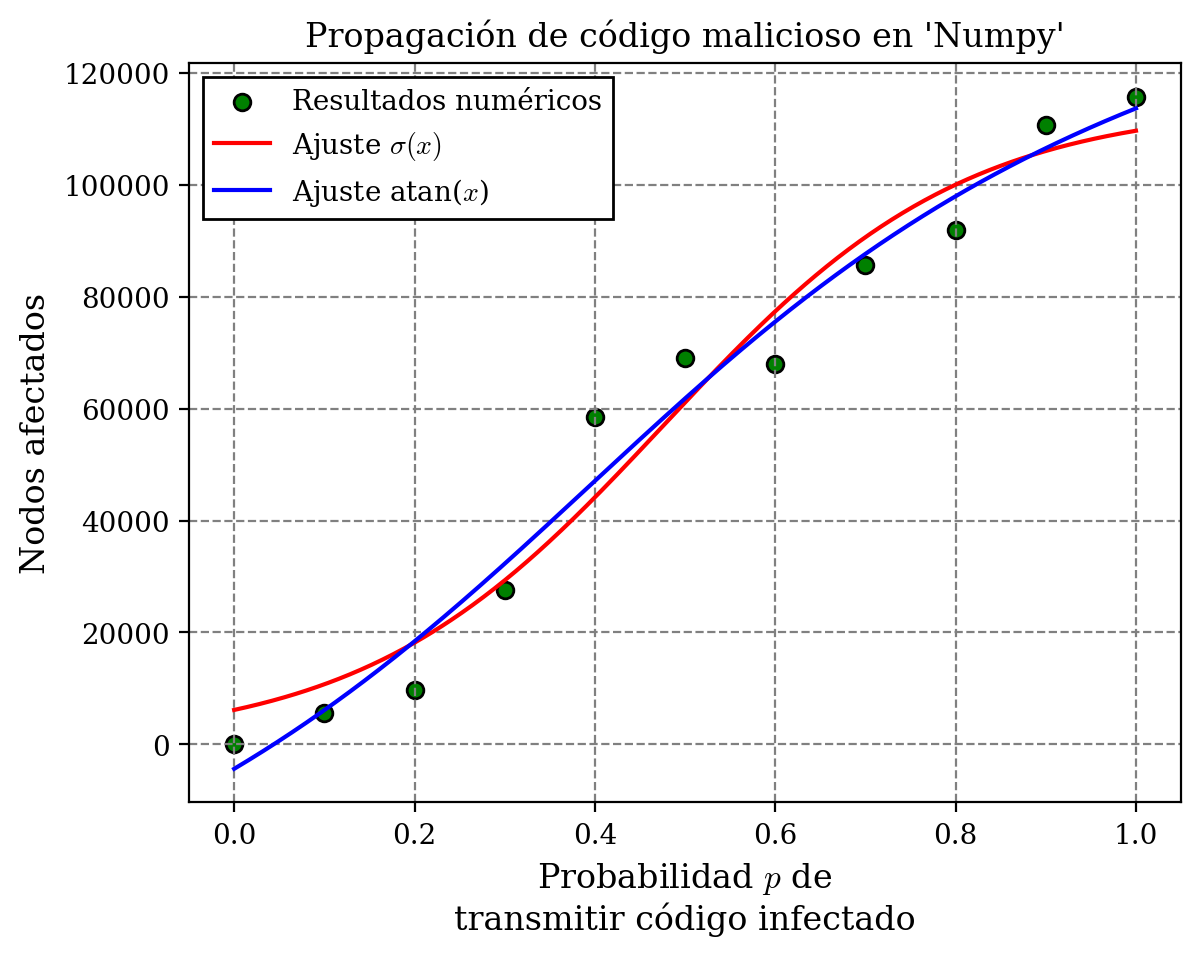

In [40]:
from scipy.optimize import curve_fit

sigmoid = lambda x, a, b, c: a/(1 + np.exp(-b*x - c))
arctan = lambda x, a, b, c, d: a*np.arctan(b*x + c) + d

popt, pcov = curve_fit(sigmoid, probs, np_probs, p0 = [120000, 1, 0.5])
popt2, pcov2 = curve_fit(arctan, probs, np_probs)
p = np.linspace(0, 1, 500)

plt.scatter(probs, np_probs, ec="black", label="Resultados numéricos", color="green")
plt.plot(p, sigmoid(p, *popt), label="Ajuste $\sigma(x)$", color="red")
plt.plot(p, arctan(p, *popt2), label="Ajuste atan($x$)", color="blue")
plt.legend(loc="upper left", fancybox=False, edgecolor="black", framealpha=1)

plt.xlabel(f"Probabilidad $p$ de\ntransmitir código infectado")
plt.ylabel(f"Nodos afectados")
plt.title("Propagación de código malicioso en 'Numpy'")
plt.grid(color="gray", ls="--")